In [1]:
import numpy as np
import torch
import torchvision
import math

import torchvision.transforms as transforms
from bgan.datasets import SynthDataset
from bgan.synth_utils import js_div, kl_div, pca
from bgan.priors import UninformativePrior, FactorizedNormalPrior
import torch.nn.functional as F

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Dataset

In [62]:
img_size = 32
transform = transforms.Compose(
    [transforms.Scale(img_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=True, num_workers=2)

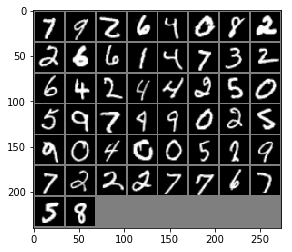

In [63]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## BGAN

In [4]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [5]:
trainset[0][0].size()

torch.Size([1, 32, 32])

In [64]:
def weight_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.zero_()
        
def gen_weight_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.zero_()
        
        
class GeneratorNetwork(nn.Module):
    # initializers
    def __init__(self, d=128, z_dim=100):
        super(GeneratorNetwork, self).__init__()
        self.init_net(d, z_dim)
        self.input_dim = z_dim
        
    def init_net(self, d, z_dim):
        self.deconv1 = nn.ConvTranspose2d(z_dim, d*4, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*4)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # forward method
    def forward(self, x):
        x = x.view((-1, self.input_dim, 1, 1))
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.tanh(self.deconv4(x))

        return x
    

class DiscriminatorNetwork(nn.Module):
    
    def __init__(self, d=128):
        super(DiscriminatorNetwork, self).__init__()
        self.init_net(d)
    
    # initializers
    def init_net(self, d):
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, 1, 4, 1, 0)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = self.conv4(x)
        x = x.squeeze()

        return x

In [65]:
gen = GeneratorNetwork()
disc = DiscriminatorNetwork()

z = Variable(torch.from_numpy(np.random.rand(10, 100)).float())
print(gen.forward(z).size())
print(disc(gen.forward(z)).size())

torch.Size([10, 1, 32, 32])
torch.Size([10])


In [66]:
from bgan.bgan_wasserstein import WBGAN

In [67]:
batch_size = 50
z_dim = 100

In [68]:
# prior = UninformativePrior()
prior = FactorizedNormalPrior(std=10.)
gen = GeneratorNetwork()
disc = DiscriminatorNetwork()
# gen.apply(weight_init)
gen.apply(gen_weight_init)
disc.apply(weight_init)
bgan = WBGAN(gen, disc, prior, alpha=.9, eta=5e-5, disc_lr = 5e-5, gen_observed=20000, MAP=False, cuda=True)
samples = []

Moving generator and discriminator to GPU
TODO: Weight Clipping constants?
TODO: RMSProp?


In [69]:
for param in gen.parameters():
    print(param.size(), np.linalg.norm(param.cpu().data.numpy()))

torch.Size([100, 512, 4, 4]) 18.1024
torch.Size([512]) 0.0
torch.Size([512]) 13.0834
torch.Size([512]) 0.0
torch.Size([512, 256, 4, 4]) 28.9589
torch.Size([256]) 0.0
torch.Size([256]) 9.07625
torch.Size([256]) 0.0
torch.Size([256, 128, 4, 4]) 14.4917
torch.Size([128]) 0.0
torch.Size([128]) 7.30314
torch.Size([128]) 0.0
torch.Size([128, 1, 4, 4]) 0.918985
torch.Size([1]) 0.0


## Training

In [70]:
num_samples = 10

In [93]:
if isinstance(samples, np.ndarray):
    samples = [samples]
    
for epoch in range(10):
    for i, data_ in enumerate(trainloader, 0):
        batch = data_[0].float()
        bgan.d_step(batch)
        if not (i%5):
            bgan.g_step(batch)
    if not epoch%1:
        batchv = Variable(batch)
        d_loss, g_loss = bgan.loss(batchv.cuda())
        print('\t', d_loss.cpu().data.numpy()[0], g_loss.cpu().data.numpy()[0])
    if not epoch%1:
        print(epoch)
    if not epoch%1:
        samples.append(bgan.sample(num_samples).cpu().data.numpy())
samples = np.vstack(samples)

	 -8253.12 3977.77
0
	 -8544.08 4695.02
1
	 -10087.9 5482.78
2
	 -11425.2 5650.92
3
	 -14639.6 7158.41
4
	 -8758.48 8699.19
5
	 -16744.9 7755.07
6
	 -20315.0 9801.01
7
	 -22887.1 11415.3
8
	 -24303.2 11946.5
9


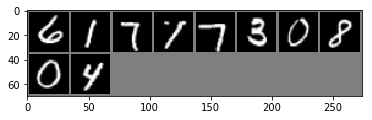

In [94]:
imshow(torchvision.utils.make_grid(batch[:10]))

In [95]:
# samples_arr = np.array(samples[:-2])
# samples_ = samples[-2:]
# samples = [samples_arr]
# samples.append(samples_[0])
# samples.append(samples_[1])
# samples = np.vstack(samples)

In [96]:
# samples = bgan.sample(100).cpu().data.numpy()

In [97]:
# samples_arr = np.vstack(samples)
samples_arr = samples

In [98]:
samples_arr.shape

(200, 1, 32, 32)

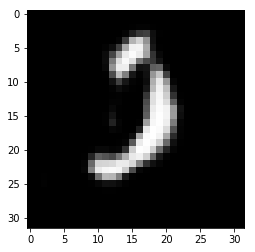

In [99]:
plt.imshow((samples_arr[-1, 0] + 1)/2, cmap='gray')

In [100]:
np.max(batch.numpy())

1.0

In [101]:
samples_arr.shape

(200, 1, 32, 32)

In [102]:
# np.save('samples/bwgan_mnist_samples.npy', samples_arr)

(-0.5, 341.5, 681.5, -0.5)

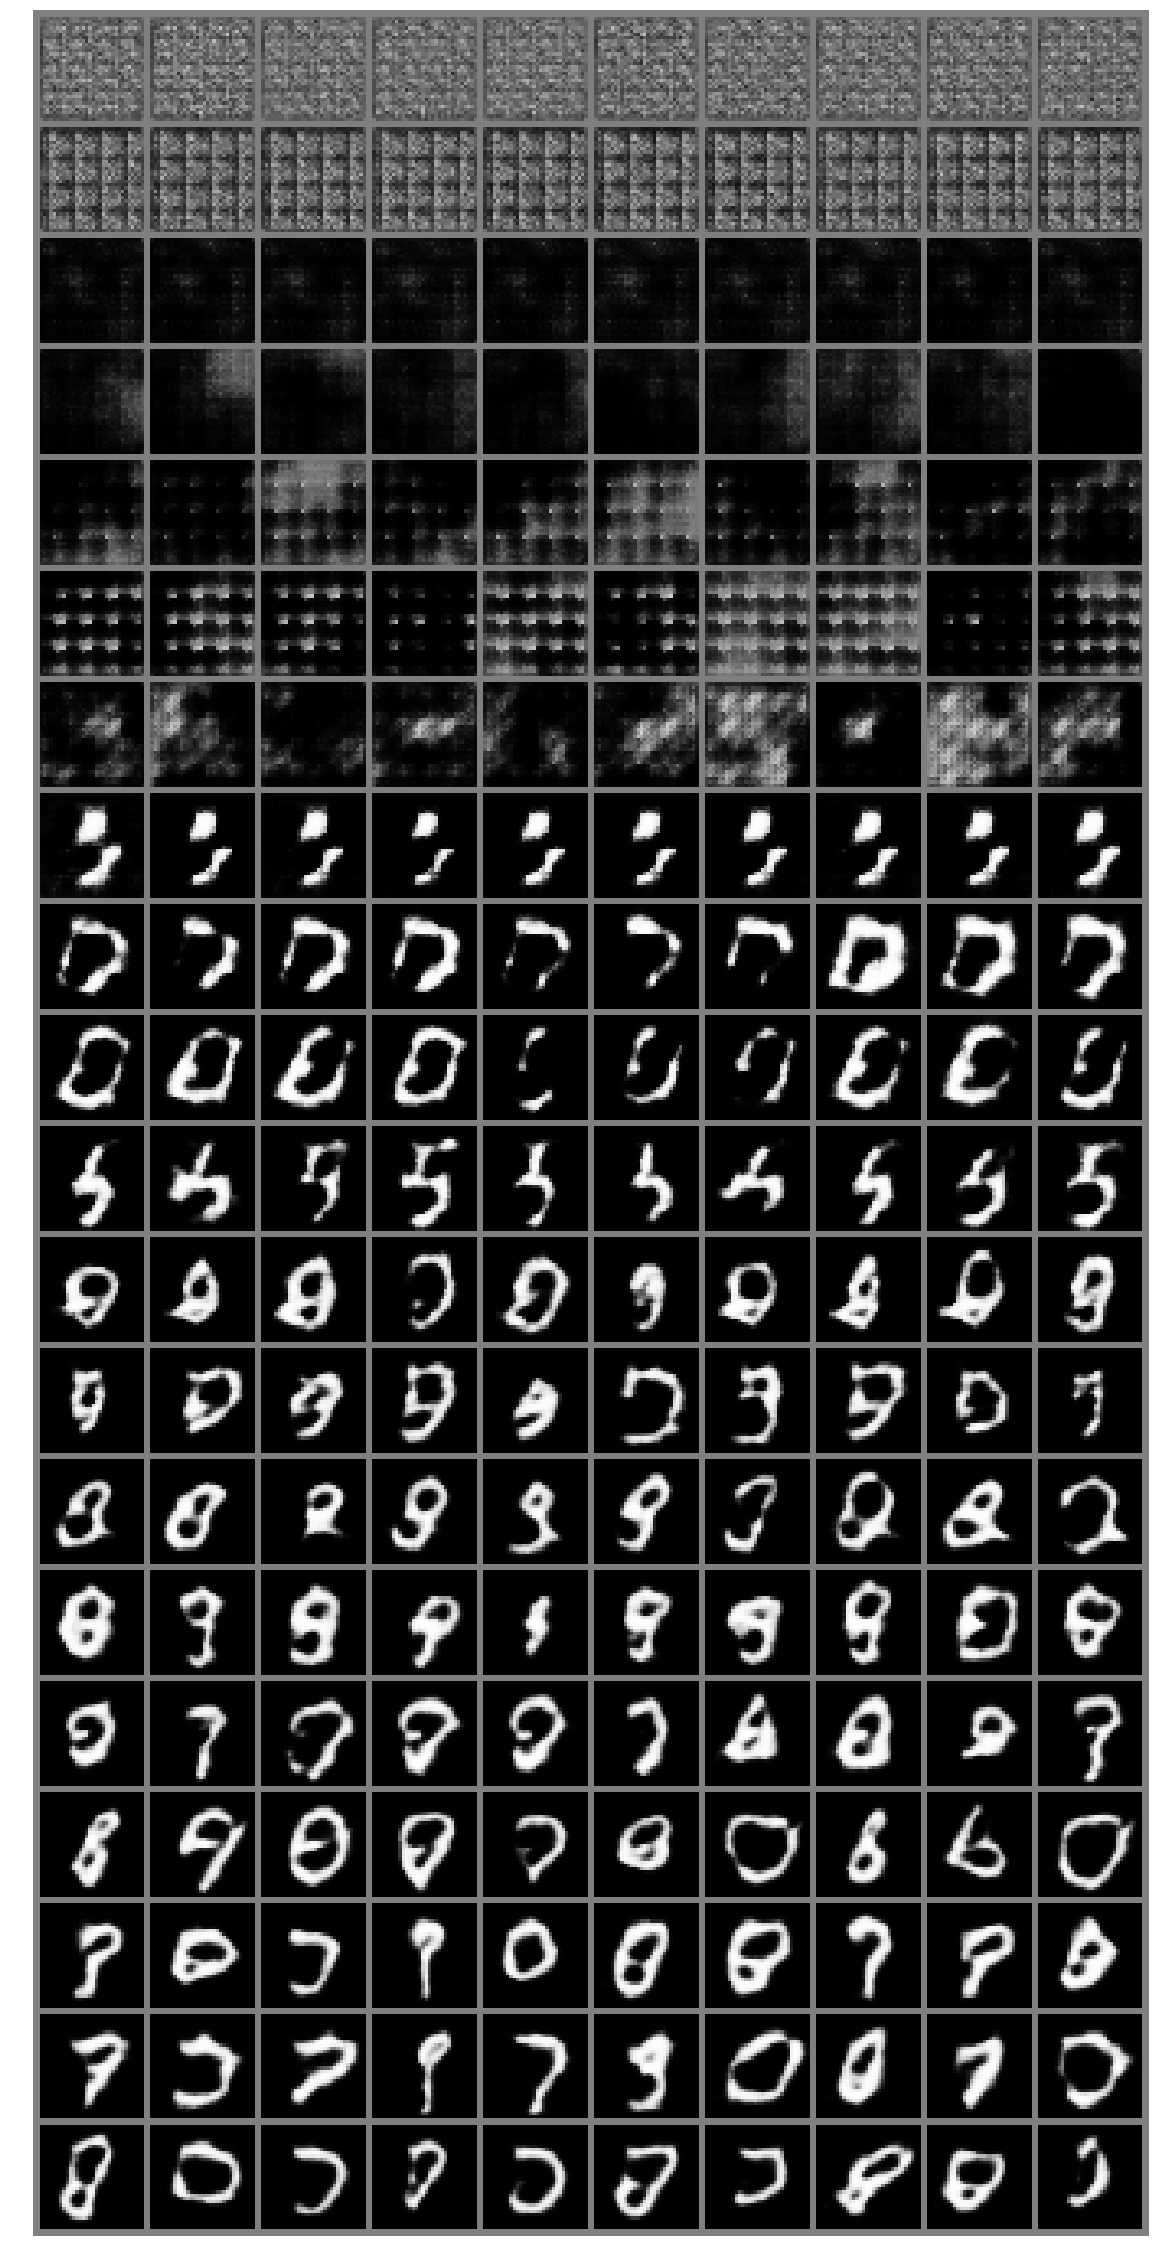

In [103]:
plt.figure(figsize=(20, 50))
show_epochs = [20, 30]
start, finish = show_epochs[0] * num_samples, (show_epochs[1]+1) * num_samples
# imshow(torchvision.utils.make_grid(torch.from_numpy(samples_arr[start:finish]), nrow=30))
imshow(torchvision.utils.make_grid(torch.from_numpy(samples_arr[:500]), nrow=10))
plt.axis('off')